In [1]:
import pandas as pd

In [2]:
df_original = pd.read_csv('singapore_trip_advisor_data_cleaned.csv')

In [3]:
df_original.head()

,REVIEW_INDEX,REVIEW_DATE,REVIEW_RATING,REVIEW_TITLE,REVIEW_BODY,DATE_OF_EXPERIENCE,TRIP_TYPE,REVIEW_CRAWLED_TIME,REVIEWER_NAME,HOME_COUNTRY,ATTRACTION_NAME,ATTRACTION_TYPE,ADDRESS,clean_text
0,741832336,2020-01-29 00:00:00.000,5,Fabulous,Fabulous experience and an unforgettable day o...,2020-01-01 00:00:00.000,Couples,2020-01-29 12:01:27.012,Dreinog,United Kingdom,Cloud Forest,Leisure & Recreation,18 Marina Gardens Drive | 18 Marina Gardens Dr...,fabulous experience unforgettable day singapor...
1,741819214,2020-01-29 00:00:00.000,5,Stunning,I wasnâ€™t sure what to expect but this was ab...,2020-01-01 00:00:00.000,Family,2020-01-29 11:30:13.663,3mcglynns,Australia,Cloud Forest,Leisure & Recreation,18 Marina Gardens Drive | 18 Marina Gardens Dr...,wasnatmt sure expect absolutely beautiful moth...
2,741818972,2020-01-29 00:00:00.000,3,Another Chinatown,As every major city worldwide seems to have a ...,2020-01-01 00:00:00.000,Couples,2020-01-30 11:53:44.082,MR_Travels1920,United Kingdom,Chinatown,Precinct & Street,"Crot | Trengganu, Singapore 048942, Singapore",every major city worldwide seem chinatown anot...
3,741881009,2020-01-29 00:00:00.000,4,Good lively place to visit,Busy lively place in the evening I visited. Go...,2020-01-01 00:00:00.000,Solo,2020-01-30 12:34:12.312,RaviA651,United States,Chinatown,Precinct & Street,"Crot | Trengganu, Singapore 048942, Singapore",busy lively place even visit go empty stomach ...
4,741827762,2020-01-29 00:00:00.000,5,Great experience,Fabulous location and atmosphere. We only stop...,2020-01-01 00:00:00.000,Couples,2020-01-29 23:02:07.201,Dreinog,United Kingdom,Marina Bay,Precinct & Street,"Marina Boulevard, Singapore 018980, Singapore",fabulous location atmosphere stop day return s...


In [4]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,f1_score,roc_auc_score,confusion_matrix,plot_confusion_matrix,roc_curve,auc
from sklearn.model_selection import train_test_split

In [5]:
import numpy as np
size = 65000        # sample size
replace = True  # without replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
df = df_original.groupby('REVIEW_RATING', as_index=False).apply(fn)




    
train_df,test_df = train_test_split(df,test_size = 0.3)


In [6]:
train_df.shape,test_df.shape

((227500, 14), (97500, 14))

In [7]:
## max df from 1 to 0.08 - accuracy unaffected
BOW = TfidfVectorizer()

X_train = train_df['clean_text']
y_train = train_df['REVIEW_RATING']
train_mat = BOW.fit_transform(X_train)


In [8]:
mnb = MultinomialNB(alpha=0.4)

In [9]:
param_grid = {
    'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
}
mnb = GridSearchCV(mnb,param_grid=param_grid,cv=5,verbose=0)
mnb.fit(train_mat,y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(alpha=0.4),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1]})

In [10]:
best_mnb = mnb.best_estimator_
mnb.best_params_

{'alpha': 0.1}

In [11]:
print(classification_report(y_train,best_mnb.predict(train_mat)))

              precision    recall  f1-score   support

           1       0.91      0.92      0.91     45516
           2       0.86      0.89      0.87     45458
           3       0.75      0.73      0.74     45507
           4       0.69      0.61      0.65     45608
           5       0.69      0.75      0.72     45411

    accuracy                           0.78    227500
   macro avg       0.78      0.78      0.78    227500
weighted avg       0.78      0.78      0.78    227500



In [12]:
X_test = test_df['clean_text']
y_test = test_df['REVIEW_RATING']
test_mat = BOW.transform(X_test)

In [13]:
print(classification_report(y_test,best_mnb.predict(test_mat)))

              precision    recall  f1-score   support

           1       0.90      0.92      0.91     19484
           2       0.85      0.88      0.86     19542
           3       0.72      0.71      0.71     19493
           4       0.62      0.55      0.59     19392
           5       0.65      0.69      0.67     19589

    accuracy                           0.75     97500
   macro avg       0.75      0.75      0.75     97500
weighted avg       0.75      0.75      0.75     97500



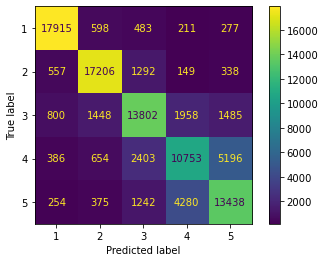

In [14]:
plot_confusion_matrix(best_mnb,test_mat,y_test);

In [15]:
confusion_matrix(y_test,mnb.predict(test_mat))

array([[17915,   598,   483,   211,   277],
       [  557, 17206,  1292,   149,   338],
       [  800,  1448, 13802,  1958,  1485],
       [  386,   654,  2403, 10753,  5196],
       [  254,   375,  1242,  4280, 13438]])

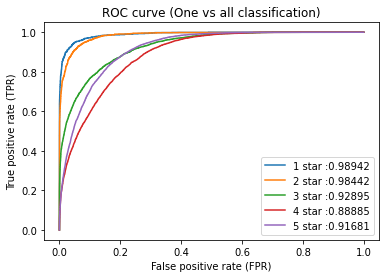

In [16]:
import matplotlib.pyplot as plt 
for i in range(1,6):
    fpr, tpr, threshold = roc_curve(np.array(y_test),mnb.predict_proba(test_mat)[:,i-1],pos_label=i)
    auc_score = auc(fpr,tpr)
    plt.plot(fpr,tpr,label = str(i)+' star :'+str(np.round(auc_score,5)))
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')
    plt.legend()

plt.title('ROC curve (One vs all classification)')
plt.show()



In [17]:
## overall
roc_auc_score(y_test,mnb.predict_proba(test_mat),multi_class='ovr')

0.9416892807928481